## Imports

In [1]:
!pip install pymoo

In [2]:
# IMPORTS
import numpy as np
import pandas as pd
import keras
from keras import layers
import random
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.core.problem import Problem
from keras.utils import to_categorical


## Classes

In [3]:
# CLASSES

class Device:
    def __init__(self, id, ram, storage, cpu, bandwidth, battery, charging):
        self.id = id
        self.ram = ram
        self.storage = storage
        self.cpu = cpu
        self.bandwidth = bandwidth
        self.battery = battery
        self.charging = charging
        self.model: keras.Sequential = Server.create_model()
        self.last_round_participated = 0
        self.data = None  # Placeholder for dataset partition
        self.test_data = None
        self.number_of_times_fitted = 0
        self.hardware_value_sum = 0.0
        
    def lose_battery(self):
        if self.hardware_value_sum > 0.3:
            self.hardware_value_sum -= 0.3
        else:
            self.hardware_value_sum = 0
            print("device turned off!")
        
        # if float(self.battery) > 0.3:
        #     self.battery -= 0.3
        # else:
        #     self.battery = 0
        #     print("device turned off!")

class Server:
    def __init__(self, devices_list: list[Device]):
        self.model: keras.Sequential = Server.create_model()
        self.current_learning_iteration = 0
        self.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES = []
        self.x_test_global = []
        self.y_test_global = []
        self.devices = devices_list
               
        # The variables below are used to keep track of the remaining rounds and generations and to store the variances
        # They do not logically belong to the Server class
        self.remaining_generation = 0
        self.remaining_round = 0
        self.variances = []  # List to store variances as [round, gen, solution, variance]
        self.pareto_fronts = [] # List to store pareto fronts as [round, gen, solution]

    def evaluate(self, x_test=None, y_test=None, verbose = 0):
        if x_test is None and y_test is None:
            test_loss, test_acc = self.model.evaluate(self.x_test_global, self.y_test_global, verbose)
            return test_loss, test_acc
        test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=verbose)
        return test_loss, test_acc

    def get_weights(self):
        return self.model.get_weights()

    def set_aggregated_weight(self):
        self.model.set_weight(Server.aggregate_weights())

    def give_global_model_weights_to_bitstring_devices(self, bitstring):
        for device in self.devices:
            if int(bitstring[int(device.id)]) == 1:
                device.model.set_weights(self.model.get_weights())

    def create_model() -> keras.Sequential:
        model = keras.Sequential([
            layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
                        # new
                        loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def aggregate_weights(self, bitstring):
        """Computes the weighted average of model weights from all devices and updates the global model."""
        def sum_all_nested_lists(list_of_lists):
            def recursive_sum(lists):
                if isinstance(lists[0], list):
                    return [recursive_sum([lst[i] for lst in lists]) for i in range(len(lists[0]))]
                else:
                    return sum(lists)

            return recursive_sum(list_of_lists)

        def multiply_nested_list(lst, factor):
            result = []
            for item in lst:
                if isinstance(item, list):
                    # Recursively handle sublists
                    result.append(multiply_nested_list(item, factor))
                else:
                    # Multiply number
                    result.append(item * factor)
            return result

        selected_devices = []
        for device in self.devices:
            if int(bitstring[int(device.id)]) == 1:
                selected_devices.append(device)

        num_devices = len(selected_devices)
        if num_devices == 0:
            print("No devices available for aggregation.")
            return

        device_participation_ratio = []
        data_lengths = []

        for device in selected_devices:
            # print("*******************")
            # print(device.id)
            device_participation_ratio.append(device.last_round_participated / self.current_learning_iteration)
            # print("this device's participation ratio:")
            # print(device.last_round_participated / self.current_learning_iteration)
            data_lengths.append(len(device.data[0]))
            # print("this device's data to all ratio:")
            # print(len(device.data[0])/60000.0)

        sum_data = 0
        for data_len in data_lengths:
            sum_data += data_len

        data_fractions = []
        for device in selected_devices:
            data_fractions.append(len(device.data[0])/float(sum_data))



        combined_weights = [fraction * ratio for fraction, ratio in zip(data_fractions, device_participation_ratio)]
        total_weight = sum(combined_weights)
        normalized_weights = [w / total_weight for w in combined_weights]
        # print(normalized_weights)


        aggregated_weights_devices = []
        for d in range(len(selected_devices)):
            # aggregated_weights_devices.append(multiply_nested_list(selected_devices[d].model.get_weights(), data_fractions[d]*device_participation_ratio[d]))
            aggregated_weights_devices.append(multiply_nested_list(self.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(selected_devices[d].id)], normalized_weights[d]))

        aggregated_weights = sum_all_nested_lists(aggregated_weights_devices)
        # TODO: Weighted multiplication for each node in each layer of the neural network of the received devices and then summing
        #       the related parts together so that we get a full weighted average of all these devices' models

        # print("Aggregated weights:")
        # for layer_idx, layer_weights in enumerate(aggregated_weights):
            # print(f"Layer {layer_idx}: {layer_weights.shape}")
            
        
        return aggregated_weights


class NodeSelectionProblem(Problem):
    def __init__(self, devices: list[Device], server: Server, max_number_of_generations, max_number_of_rounds):
        super().__init__(
            n_var=len(devices),         # Number of variables (bitstring length)
            n_obj=3,                   # Number of objectives
            n_constr=0,                # No constraints
            xl=np.zeros(len(devices)),  # Lower bound (0)
            xu=np.ones(len(devices)),   # Upper bound (1)
            type_var=np.bool_          # Binary variables (bitstrings)
        )
        self.MAX_NUMBER_OF_GENERATIONS = max_number_of_generations
        self.MAX_NUMBER_OF_ROUNDS = max_number_of_rounds
        self.devices = devices
        self.server = server
        self.x_test_global = server.x_test_global
        self.y_test_global = server.y_test_global

        # Save the initial global model weights
        self.initial_global_weights = server.get_weights()

    def _evaluate(self, X, out, *args, **kwargs):
        MAX_NUMBER_OF_GENERATIONS = self.MAX_NUMBER_OF_GENERATIONS
        MAX_NUMBER_OF_ROUNDS = self.MAX_NUMBER_OF_ROUNDS
        """Evaluates objective values for each solution in the population."""
        num_solutions = len(X)
        F = np.zeros((num_solutions, 3))  # Initialize objective matrix

        for i, bitstring in enumerate(X):
            # print(f"evaluating: {bitstring}")
            # TODO: check bitstring type
            # Reset the global model to its initial state
            # Update device participation based on the bitstring
            selected_devices = [device for device, bit in zip(self.devices, bitstring) if int(bit) == 1]

            # Objective 1: Hardware Objectives (maximize)
            hardware_score = 0.0
            for device in selected_devices:
                device_hardware_score = float(6 - (device.hardware_value_sum)) / 6.0
                hardware_score += device_hardware_score

            F[i, 0] = round(hardware_score/len(selected_devices), 2)  # Minimize (negative of hardware score)

            # Objective 2: Fairness (maximize)
            fairness_score = 0
            list_of_global_model_on_device_test_data_accuracies = []
            for device in self.devices:
                if int(bitstring[int(device.id)]) == 1:
                    _, accuracy = self.server.evaluate(device.test_data[0], device.test_data[1], verbose=0)
                    accuracy = round(accuracy, 2)
                    list_of_global_model_on_device_test_data_accuracies.append(accuracy)
                    fairness_score += accuracy
                    
            # round_to_save = MAX_NUMBER_OF_ROUNDS - self.server.remaining_round
            # generation_to_save = MAX_NUMBER_OF_GENERATIONS - self.server.remaining_generation
            # solution_to_save = str(bitstring).replace('True', '1').replace('False', '0').replace('  ',' ').replace('[ ','[').replace('\n', '').replace(' ', ',')
            # variance_to_save = round(1.0 / float(np.var(list_of_global_model_on_device_test_data_accuracies)), 2)
            # self.server.variances.append([round_to_save, generation_to_save, solution_to_save, variance_to_save])
            
            # with open("variances.txt", 'a') as f:
            #     f.write(f"{str(bitstring).replace('True', '1').replace('False', '0').replace('  ',' ').replace('[ ','[').replace('\n', '').replace(' ', ',')}\nround: {MAX_NUMBER_OF_ROUNDS - self.server.remaining_round} gen: {MAX_NUMBER_OF_GENERATIONS - self.server.remaining_generation} variance: {round(1.0 / float(np.var(list_of_global_model_on_device_test_data_accuracies)), 2)}\n")

            

            F[i, 1] = round(1.0 - (fairness_score/float(len(selected_devices))), 2)  # Minimize (negative of fairness score)  # Added (/Selected Devices) to normalize between 0 and 1

            # Objective 3: Global Model Accuracy (Performance) (maximize)
            temp_global_model = Server.create_model()
            temp_global_model.set_weights(self.performance_objective_aggregation(selected_devices))
            _, global_accuracy = temp_global_model.evaluate(self.server.x_test_global, self.server.y_test_global, verbose=0)
            F[i, 2] = round(1 - global_accuracy, 2)  # Minimize (1 - accuracy)

        self.server.remaining_generation -= 1
        out["F"] = F  # Set the objective values

    def performance_objective_aggregation(self, selected_devices):

        def sum_all_nested_lists(list_of_lists):
            def recursive_sum(lists):
                if isinstance(lists[0], list):
                    return [recursive_sum([lst[i] for lst in lists]) for i in range(len(lists[0]))]
                else:
                    return sum(lists)

            return recursive_sum(list_of_lists)

        def multiply_nested_list(lst, factor):
            result = []
            for item in lst:
                if isinstance(item, list):
                    # Recursively handle sublists
                    result.append(multiply_nested_list(item, factor))
                else:
                    # Multiply number
                    result.append(item * factor)
            return result

        num_devices = len(selected_devices)
        if num_devices == 0:
            print("No devices available for aggregation.")
            return

        device_weights_all_layers = []
        device_participation_ratio = []
        # device_participation_weights = []
        data_lengths = []

        for device in selected_devices:
            device_weights_all_layers.append(self.server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(device.id)])
            # print("*******************")
            # print(device.id)
            device_participation_ratio.append(device.last_round_participated / self.server.current_learning_iteration)
            # device_participation_weights.append(device.last_round_participated)
            # print("this device's participation ratio:")
            # print(device.last_round_participated / self.server.current_learning_iteration)

            data_lengths.append(len(device.data[0]))
            # print("this device's data to all ratio:")
            # print(len(device.data[0])/60000.0)

        sum_data = 0
        for data_len in data_lengths:
            sum_data += data_len

        # data_weights = []
        data_fractions = []
        for device in selected_devices:
            data_fractions.append(len(device.data[0])/float(sum_data))
            # data_weights.append(len(device.data[0]))


        # new:
        # weights = []
        combined_weights = [fraction * ratio for fraction, ratio in zip(data_fractions, device_participation_ratio)]
        total_weight = sum(combined_weights)
        normalized_weights = [w / total_weight for w in combined_weights]
        # print(normalized_weights)


        aggregated_weights_devices = []
        for d in range(len(selected_devices)):
            # aggregated_weights_devices.append(multiply_nested_list(self.server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(selected_devices[d].id)], data_fractions[d]*device_participation_ratio[d]))
            aggregated_weights_devices.append(multiply_nested_list(self.server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(selected_devices[d].id)], normalized_weights[d]))


        aggregated_weights = sum_all_nested_lists(aggregated_weights_devices)

        # print("Aggregated weights:")
        # for layer_idx, layer_weights in enumerate(aggregated_weights):
        #     print(f"Layer {layer_idx}: {layer_weights.shape}")
        return aggregated_weights




## Functions

In [4]:
# Functions

def fit_bitstring_devices(bitstring, server: Server, epochs=7):
    '''
    server: for using its "current_learning_iteration" variable
    '''

    server.current_learning_iteration += 1
    for device in server.devices:
        if int(bitstring[int(device.id)]) == 1:
            # TODO:
            # makes it so that the selection might choose a device that's been turned off
            # if the device is off, don't fit, use old weights saved on the server.
            # if the device is on, fit, update the weights saved on the server.
            # TODO:
            # COMMENTED FOR NOW, SINCE IT ALREADY AFFECTS NSGA2 EVALUATION
            
            # if device.hardware_value_sum :
            #     continue
            
            device.lose_battery()
            
            device.model.fit(device.data[0], device.data[1], epochs=epochs, verbose=0)
            # print(device.id)
            device.last_round_participated = server.current_learning_iteration
            server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(device.id)] = device.model.get_weights()
            device.number_of_times_fitted += 1




def niid_labeldir_split(x_data, y_data, num_clients, beta, seed=None):
    num_classes = 10
    y_indices = np.array([np.argmax(label) for label in y_data])  # From one-hot to class index
    
    rng = np.random.default_rng(seed)  # Local random generator

    # Prepare client partitions
    client_indices = [[] for _ in range(num_clients)]

    for k in range(num_classes):
        idx_k = np.where(y_indices == k)[0]
        rng.shuffle(idx_k)

        # Dirichlet distribution for class k
        proportions = rng.dirichlet(np.repeat(beta, num_clients))

        # Scale proportions to match the number of available samples
        proportions = np.array([int(p * len(idx_k)) for p in proportions])
        # Fix total due to rounding
        while sum(proportions) < len(idx_k):
            proportions[np.argmin(proportions)] += 1
        while sum(proportions) > len(idx_k):
            proportions[np.argmax(proportions)] -= 1

        start = 0
        for i in range(num_clients):
            size = proportions[i]
            client_indices[i].extend(idx_k[start:start + size])
            start += size

    return client_indices



def random_hardware_value_for_devices(devices: list[Device]):
    random_values = [3.91, 0.62, 1.79, 4.96, 5.87, 2.14, 1.41, 5.18, 2.80, 3.00, 0.20, 1.02, 5.73, 0.69, 4.27,
                     5.37, 1.62, 0.93, 3.61, 2.90, 4.53, 2.13, 3.01, 0.07, 1.34, 3.90, 0.28, 1.89, 5.95, 2.76]
    
    for idx in range(len(devices)):
        devices[idx].hardware_value_sum = random_values[idx]
    
    print("Successfully gave each device a random value between 0 and 6 for its hardware objective!")


## Load Data

### Load Devices

In [5]:
# Load dataset from CSV
csv_file = 'devices.csv'
df = pd.read_csv(csv_file)
df.columns = df.columns.str.strip().str.lower()

# Convert CSV rows into device objects
devices = []

for _, row in df.iterrows():
    device = Device(
        row['id'], row['ram'], row['storage'], row['cpu'], row['bandwidth'], row['battery'],
        row.get('charging', 0)
    )
    devices.append(device)


# LIMIT TO 30 DEVICES
devices = devices[:30]

random_hardware_value_for_devices(devices)

d:\Github Repos\FL\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Successfully gave each device a random value between 0 and 6 for its hardware objective!


### Object Initializations

In [6]:
# Global Model
server = Server(devices_list=devices)
server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES = [None for _ in range(len(devices))]

### Split Data Among Devices

In [7]:
SEED = 1
np.random.seed(SEED)
np.random.random_integers(1, 10)

C:\Users\lotus\AppData\Local\Temp\ipykernel_26840\3508582103.py:3: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  np.random.random_integers(1, 10)


np.int32(6)

In [8]:


# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Convert labels to categorical (one-hot encoded)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Normalize data and reshape for CNN
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # Add channel dimension

x_test = x_test.astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1)  # Add channel dimension

# Shuffle data
# indices = np.arange(len(x_train))
# np.random.shuffle(indices)
# x_train, y_train = x_train[indices], y_train[indices]




# Lower the amount of data for devices
x_train = x_train[:int(len(x_train)/6)] # was 8
y_train = y_train[:int(len(y_train)/6)]




# Correct test split
split_index = int(0.8 * len(x_test))
x_test_devices, y_test_devices = x_test[:split_index], y_test[:split_index]
server.x_test_global, server.y_test_global = x_test[split_index:], y_test[split_index:]

# Training data (for devices)
x_train_devices, y_train_devices = x_train, y_train

# Split training data among devices
beta = 0.5  # lower = more skewed
num_devices = len(devices)
split_indices = niid_labeldir_split(x_train_devices, y_train_devices, num_devices, beta, seed=SEED)

for i, device in enumerate(devices):
    idxs = split_indices[i]

    from sklearn.model_selection import train_test_split

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(x_train_devices[idxs], y_train_devices[idxs], test_size=0.3, random_state=42)

    device.data = [X_train, y_train]
    device.test_data = [X_test, y_test]

    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)


#TODO:
# how does each objective get better through populations? maybe put em on a scale

X_train shape: (118, 28, 28, 1)
X_test shape: (51, 28, 28, 1)
y_train shape: (118, 10)
y_test shape: (51, 10)
X_train shape: (104, 28, 28, 1)
X_test shape: (45, 28, 28, 1)
y_train shape: (104, 10)
y_test shape: (45, 10)
X_train shape: (151, 28, 28, 1)
X_test shape: (66, 28, 28, 1)
y_train shape: (151, 10)
y_test shape: (66, 10)
X_train shape: (220, 28, 28, 1)
X_test shape: (95, 28, 28, 1)
y_train shape: (220, 10)
y_test shape: (95, 10)
X_train shape: (291, 28, 28, 1)
X_test shape: (125, 28, 28, 1)
y_train shape: (291, 10)
y_test shape: (125, 10)
X_train shape: (182, 28, 28, 1)
X_test shape: (78, 28, 28, 1)
y_train shape: (182, 10)
y_test shape: (78, 10)
X_train shape: (186, 28, 28, 1)
X_test shape: (81, 28, 28, 1)
y_train shape: (186, 10)
y_test shape: (81, 10)
X_train shape: (157, 28, 28, 1)
X_test shape: (68, 28, 28, 1)
y_train shape: (157, 10)
y_test shape: (68, 10)
X_train shape: (357, 28, 28, 1)
X_test shape: (154, 28, 28, 1)
y_train shape: (357, 10)
y_test shape: (154, 10)
X_trai

In [9]:
# test
a, b =devices[23].test_data
print(len(a))

110


### Load Other Data

## First Iteration

In [10]:
# First Iteration
bitstring = [1 for _ in range(len(devices))]
print(bitstring)



# Save weights to a file
# The file name should end in .weights.h5
# The weights can be loaded into a model using model.load_weights('model.weights.h5')
server.model.save_weights('my_model.weights.h5')

# global model sends its weights to all devices
server.give_global_model_weights_to_bitstring_devices(bitstring)



test_loss, test_acc = server.evaluate(verbose=0)
print(f"Global Model Accuracy: {test_acc:.2f}")
print("------------------------------------------------------------")
fit_bitstring_devices(bitstring, server)
server.model.set_weights(server.aggregate_weights(bitstring))
print("------------------------------------------------------------")
test_loss, test_acc = server.evaluate(verbose=0)
print(f"Global Model Accuracy: {test_acc:.2f}")

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1204 - loss: 2.2843
Global Model Accuracy: 0.11
------------------------------------------------------------
device turned off!
device turned off!
device turned off!
------------------------------------------------------------
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6817 - loss: 1.6931
Global Model Accuracy: 0.67


In [11]:
!pip install pymoo

## NSGA2 Loop

In [12]:
# Parameters
POPULATION_SIZE = 100 # should be 100
NUM_GENERATIONS = 10 # should be 10
NUM_ROUNDS = 4 # should be 4

server.remaining_generation = NUM_GENERATIONS
server.remaining_round = NUM_ROUNDS

In [13]:
# Object Initializations

problem = NodeSelectionProblem(
    devices=devices,
    server=server,
    max_number_of_generations=NUM_GENERATIONS,
    max_number_of_rounds=NUM_ROUNDS
)


# Step 2: Configure NSGA-II Algorithm
algorithm = NSGA2(
    pop_size=POPULATION_SIZE,
    sampling=BinaryRandomSampling(),      # Random bitstrings
    crossover=TwoPointCrossover(),        # Two-point crossover
    mutation=BitflipMutation(),           # Bit flip mutation
    eliminate_duplicates=True             # Avoid duplicate solutions
)


In [14]:
# DEBUG:
print(server.x_test_global.shape)
print(server.y_test_global.shape)

print(x_train.shape)
print(y_train.shape)

(2000, 28, 28, 1)
(2000, 10)
(10000, 28, 28, 1)
(80, 10)


In [15]:
from pymoo.core.callback import Callback
import numpy as np

class ParetoLogger(Callback):
    def __init__(self, server: Server, devices: list[Device], max_rounds, max_generations):
        super().__init__()
        self.data["pareto_fronts"] = []     # Objective values F
        self.data["pareto_solutions"] = []  # Decision variables X
        
        
        
        self.server = server
        self.devices = devices
        self.max_rounds = max_rounds
        self.max_generations = max_generations
        self.variances = []  # Store variances as [round, gen, bitstring, variance]

    def notify(self, algorithm):
        opt = algorithm.opt
        gen = algorithm.n_gen
        if opt is not None:
            F = opt.get("F")
            X = opt.get("X")
            print(f"Generation {gen}: {len(X)} solutions in opt")  # ← Check this!
            self.data["pareto_fronts"].append(F.copy())
            self.data["pareto_solutions"].append(X.copy())
        
        
        
        
        
        
        # Get current round and generation
        round_idx = self.max_rounds - self.server.remaining_round
        gen_idx = self.max_generations - self.server.remaining_generation + 1  # Adjust for current gen

        # Get the non-dominated solutions (Pareto front) from the current population
        pop = algorithm.opt  # Non-dominated solutions (Pareto front)

        for ind in pop:
            bitstring = ind.X  # Bitstring for this individual
            bitstring_str = "".join(map(str, bitstring)).replace("True", "1").replace("False", "0")

            # Select devices based on the bitstring
            selected_devices = [device for device, bit in zip(self.devices, bitstring) if int(bit) == 1]

            # Calculate fairness (variance of global model accuracy on selected devices' test data)
            accuracies = []
            for device in selected_devices:
                _, accuracy = self.server.evaluate(device.test_data[0], device.test_data[1], verbose=0)
                accuracies.append(round(accuracy, 2))

            # Compute variance (handle edge case of no selected devices)
            if not accuracies:
                variance = 0.0  # Default value if no devices are selected
                print(f"No devices selected for bitstring {bitstring_str}, setting variance to 0")
            else:
                variance = round(1.0 / float(np.var(accuracies)) if np.var(accuracies) != 0 else float('inf'), 2)

            # Store the result
            self.variances.append([round_idx, gen_idx-2, bitstring_str, variance])
            print(f"Round {round_idx}, Gen {gen_idx-2}, Bitstring {bitstring_str}, Variance {variance}")

        # Optionally, update server.variances if you want to keep using it
        self.server.variances.extend(self.variances[-len(pop):])

In [16]:
all_runs_fronts = []  # Stores results across runs
all_runs_solutions = []

VARIANCES = []

needed_values_for_comparison = ""

for i in range(NUM_ROUNDS):
    server.remaining_round = NUM_ROUNDS - i
    server.remaining_generation = NUM_GENERATIONS
    # Step 3: Run Optimization
    print("GLOBAL MODEL BEFORE OPTIMIZATION")
    print(server.evaluate())

    callback = ParetoLogger(server=server, devices=server.devices, max_rounds=NUM_ROUNDS, max_generations=NUM_GENERATIONS)
    res = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=DefaultMultiObjectiveTermination(n_max_gen=NUM_GENERATIONS),
        # seed=42,
        verbose=True,
        callback=callback
    )
    print("GLOBAL MODEL AFTER OPTIMIZATION")
    print(server.evaluate())


    # Step 4: Extract the Best Pareto Front
    pareto_front = res.F   # Objective values of solutions in Pareto front
    pareto_solutions = res.X  # Corresponding bitstrings

    # Print the Best Pareto Front Solutions
    # print("Best Pareto Front (Bitstrings):")
    # for bitstring in pareto_solutions:
        # print("".join(map(str, bitstring)).replace('True','1').replace('False','0'))

    bitstring = pareto_solutions[0] # for now!
    bitstring = str(bitstring).replace('False','0').replace('True','1')
    for char in bitstring:
        if char != '0' and char != '1':
            bitstring = bitstring.replace(char,'')

    # print(len(bitstring))
    # print(bitstring)
    temp_bitstring = []
    for bit in bitstring:
        temp_bitstring.append(bit)
    bitstring = temp_bitstring

    # a = server.model.get_weights()
    
    # NEW:
    ###############################
    bitstring = [int(bit) for bit in bitstring]
    print(bitstring)
    print(bitstring[0])
    print(type(bitstring[0]))
    # global model sends its weights to all devices
    server.give_global_model_weights_to_bitstring_devices(bitstring)

    test_loss, test_acc = server.evaluate(verbose=0)
    print(f"Global Model Accuracy: {test_acc:.2f}")
    print("------------------------------------------------------------")
    fit_bitstring_devices(bitstring, server)
    server.model.set_weights(server.aggregate_weights(bitstring))
    print("------------------------------------------------------------")
    test_loss, test_acc = server.evaluate(verbose=0)
    print(f"Global Model Accuracy: {test_acc:.2f}")
    

    # Save the pareto fronts from this run
    all_runs_fronts.append(callback.data["pareto_fronts"])
    all_runs_solutions.append(callback.data["pareto_solutions"])

    # Save the variances from this run
    VARIANCES.extend(callback.variances)
    
    
    
    # ---
    
    accuracies = []

    for device in server.devices:
        x_test = device.test_data[0]
        y_test = device.test_data[1]
        
        loss, accuracy = server.evaluate(x_test, y_test)
        
        accuracies.append(round(accuracy, 2))
        print(f"Device {device.id} Accuracy: {round(accuracy, 2)}")

    VARIANCE = np.var(accuracies)
    VARIANCE_SCORE = 1.0/VARIANCE
    MEAN = np.mean(accuracies)
    STANDARD_DEVIATION = np.std(accuracies)
    FAIRNESS = 1.0/STANDARD_DEVIATION
    
    needed_values_for_comparison += f"Round: {i+1}\nServer Test Accuracy: {test_acc}\nVariance: {VARIANCE}\nVariance Score: {VARIANCE_SCORE}\nMean: {MEAN}\nStandard Deviation: {STANDARD_DEVIATION}\nFairness: {FAIRNESS}\n---\n"

GLOBAL MODEL BEFORE OPTIMIZATION
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6817 - loss: 1.6931
(1.725033164024353, 0.6650000214576721)


d:\Github Repos\FL\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      7 |             - |             -
Generation 1: 7 solutions in opt
Round 0, Gen 0, Bitstring 001111011001111110101001000011, Variance 113.35
Round 0, Gen 0, Bitstring 101011101101101100110010000101, Variance 61.58
Round 0, Gen 0, Bitstring 000110011000101011110111011000, Variance 130.69
Round 0, Gen 0, Bitstring 000111111000101100110101110001, Variance 171.31
Round 0, Gen 0, Bitstring 100110001010001110101100010110, Variance 129.11
Round 0, Gen 0, Bitstring 001111001100001111100100110010, Variance 66.73
Round 0, Gen 0, Bitstring 001010111001010010010011000000, Variance 70.79
     2 |      200 |     11 |  0.1428571429 |         ideal
Generation 2: 11 solutions in opt
Round 0, Gen 1, Bitstring 001111011001111110101001000011, Variance 113.35
Round 0, Gen 1, Bitstring 000110011000101011110111011000, Variance 130.69
Round 0, Gen 1, Bitstring 100110001010001110101100010110, Variance 129.11
Round 0, Gen 1, Bit

In [17]:
print(len(all_runs_fronts))
print(len(all_runs_solutions))

print(len(all_runs_fronts[0][0]))
print(all_runs_fronts[0][0])

4
4
7
[[0.48 0.31 0.38]
 [0.51 0.32 0.33]
 [0.52 0.29 0.34]
 [0.48 0.34 0.34]
 [0.44 0.34 0.39]
 [0.5  0.33 0.28]
 [0.65 0.28 0.44]]


In [18]:
print(len(all_runs_solutions[0]))
print(str(all_runs_solutions[0][0][0]).replace("True", "1").replace("False", "0").replace("  ", " ").replace("[ ","[").replace(" ",",").replace("\n",""))

10
[0,0,1,1,1,1,0,1,1,0,0,1,1,1,1,1,1,0,1,0,1,0,0,1,0,0,0,0,1,1]


In [19]:
print(server.variances[0])

[0, 0, '001111011001111110101001000011', 113.35]


In [20]:
print([str(solution).replace("True", "1").replace("False", "0").replace("  ", " ").replace("[ ","[").replace(" ",",").replace("\n","") for solution in all_runs_solutions[1][1]])
print(([i[2] for i in server.variances if i[0] == 1 and i[1] == 1]))

x = [str(solution).replace("True", "1").replace("False", "0").replace("  ", " ").replace("[ ","[").replace(" ",",").replace("\n","") for solution in all_runs_solutions[1][1]]
y = ([i[2] for i in server.variances if i[0] == 1 and i[1] == 1])

for item in x:
    if item in y:
        print("yea")
    else:
        print(item)
        print("nope")

['[0,0,0,1,1,0,0,1,0,1,1,1,1,0,1,1,0,0,0,0,1,0,0,1,1,1,0,1,0,0]', '[1,0,1,1,1,1,1,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,1,1,0]', '[0,0,0,1,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0]', '[1,0,1,0,1,0,1,0,0,0,0,1,0,1,1,1,1,0,0,1,0,1,1,1,1,1,0,0,1,1]', '[1,0,0,1,1,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1]', '[1,0,1,0,0,1,0,1,1,1,0,0,0,1,1,1,1,1,1,0,1,0,1,0,0,0,0,0,1,0]', '[0,0,0,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,1,0,1,1,0,1,1,0,1,1,1,1]', '[0,0,1,1,1,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1,1]', '[1,0,0,0,1,1,1,1,0,1,0,0,1,1,1,1,0,1,0,1,0,0,1,0,1,1,0,0,0,0]', '[1,1,0,1,1,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1]', '[1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0]', '[1,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1]', '[0,0,0,1,1,0,0,1,0,1,1,1,1,0,1,1,0,0,1,0,1,0,0,1,1,1,0,1,0,0]', '[0,1,1,1,1,0,0,1,0,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,0,0,1]', '[1,0,1,1,1,1,1,0,1,1,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0]', '[1,0,1,1,1,1,1,1,0,0,0,

In [21]:

for run_index in range(len(all_runs_solutions)):
    for gen_index in range(len(all_runs_solutions[run_index])):
        for solution_index in range(len(all_runs_solutions[run_index][gen_index])):
            s = str(all_runs_solutions[run_index][gen_index][solution_index]).replace("True", "1").replace("False", "0").replace("  ", " ").replace("[ ","[").replace(" ",",").replace("\n","")
            for variance_index in range(len(server.variances)):
                if server.variances[variance_index][0] == run_index and server.variances[variance_index][1] == gen_index and server.variances[variance_index][2] == s:
                    print(f"run_index: {run_index}, gen_index: {gen_index}, solution: {s}, variance_index: {server.variances[variance_index][3]}")
            

In [22]:
# x = objective 1
# y = objective 2
# z = objective 3

def get_min_objective_value(run_index: int, generation_index: int, objective_index: int, verbose: int=0):
    temp_list = []
    for solution_objective_values in all_runs_fronts[run_index][generation_index]:
        temp_list.append(solution_objective_values[objective_index])
    if verbose == 1:
        print(f"For the run index {run_index} and generation index {generation_index}:")
        print(f"MIN of objective index {objective_index}: {min(temp_list)}")
    return min(temp_list)

def get_max_objective_value(run_index: int, generation_index: int, objective_index: int, verbose: int=0):
    temp_list = []
    for solution_objective_values in all_runs_fronts[run_index][generation_index]:
        temp_list.append(solution_objective_values[objective_index])
    if verbose == 1:
        print(f"For the run index {run_index} and generation index {generation_index}:")
        print(f"MAX of objective index {objective_index}: {max(temp_list)}")
    return max(temp_list)

In [23]:
def save_run_gen_to_file(run_index: int, gen_index: int, verbose: int = 0):
    output = ""
    for solution_index in range(len(all_runs_solutions[run_index][gen_index])):
        s = str(all_runs_solutions[run_index][gen_index][solution_index]).replace("True", "1").replace("False", "0").replace("  ", " ").replace("[ ","[").replace(" ",",").replace("\n","")
        if verbose == 1:
            print(f"solution: {s}")
        output += f"solution: {s}\n"

        if verbose == 1:
            print(f"obj1: {all_runs_fronts[run_index][gen_index][solution_index][0]}")
        output += f"obj1: {all_runs_fronts[run_index][gen_index][solution_index][0]}\n"
        
        if verbose == 1:
            print(f"obj2: {all_runs_fronts[run_index][gen_index][solution_index][1]}")
        output += f"obj2: {all_runs_fronts[run_index][gen_index][solution_index][1]}\n"
        
        if verbose == 1:
            print(f"obj3: {all_runs_fronts[run_index][gen_index][solution_index][2]}")
        output += f"obj3: {all_runs_fronts[run_index][gen_index][solution_index][2]}\n"
        
        if verbose == 1:
            print("--------------")
        output += "--------------\n"

    with open(f"run_{run_index}_gen_{gen_index}.txt", "w") as f:
        f.write(output)
    
    
for run_index in range(len(all_runs_fronts)):
    for gen_index in range(len(all_runs_fronts[run_index])):
        save_run_gen_to_file(run_index=run_index, gen_index=gen_index)

In [24]:
import plotly.graph_objects as go

# Choose a generation and run
# gen_idx = 0
# run_idx = 0

for run_idx in range(len(all_runs_fronts)):
    for gen_idx in range(len(all_runs_fronts[run_idx])):
        
        front = all_runs_fronts[run_idx][gen_idx]

        fig = go.Figure(data=[go.Scatter3d(
            x=front[:, 0],
            y=front[:, 1],
            z=front[:, 2],
            mode='markers',
            marker=dict(
                size=5,
                color=front[:, 2],  # Color by third objective
                colorscale='Viridis',
                opacity=0.8
            )
        )])

        # min_x = get_min_objective_value(run_idx, gen_idx, 0)
        # max_x = get_max_objective_value(run_idx, gen_idx, 0)
        # min_y = get_min_objective_value(run_idx, gen_idx, 1)
        # max_y = get_max_objective_value(run_idx, gen_idx, 1)
        # min_z = get_min_objective_value(run_idx, gen_idx, 2)
        # max_z = get_max_objective_value(run_idx, gen_idx, 2)
        
        min_x = 0
        min_y = 0
        min_z = 0

        max_x = 1
        max_y = 1
        max_z = 1

        fig.update_layout(
            title=f"Pareto Front - Round {run_idx}, Gen {gen_idx}",
            scene=dict(
                xaxis=dict(title="Objective 1", range=[min_x, max_x]),
                yaxis=dict(title="Objective 2", range=[min_y, max_y]),
                zaxis=dict(title="Objective 3", range=[min_z, max_z])
            )
        )

        fig.show()


In [25]:
# Step 4: Extract the Best Pareto Front
pareto_front = res.F   # Objective values of solutions in Pareto front
pareto_solutions = res.X  # Corresponding bitstrings

# Print the Best Pareto Front Solutions
print("Best Pareto Front (Bitstrings):")
for bitstring in pareto_solutions:
    print("".join(map(str, bitstring)).replace('True','1').replace('False','0'))

bitstring = pareto_solutions[0] # for now!
bitstring = str(bitstring).replace('False','0').replace('True','1')
for char in bitstring:
    if char != '0' and char != '1':
        bitstring = bitstring.replace(char,'')

print(len(bitstring))
print(bitstring)
temp_bitstring = []
for bit in bitstring:
    temp_bitstring.append(bit)
bitstring = temp_bitstring

########################################################

Best Pareto Front (Bitstrings):
000000010000100100001000010010
000110010000101001101010010110
000110000000101100001000010100
001010000000100000010010000110
001010110000000011110010000100
000110010000100000001000010110
000110010000101100001100010100
100110011100001100011000010010
101010110000101000001000010100
000110000000001100001000010100
100010010000100001110110000101
000010111000100000000010000100
000000010000101100001000010010
100000010000101100001000010010
000010011100101111110010010110
101010110000101101110000010101
001000010000101100001010010010
101010110000100010110000010100
000010010000100000000000010010
101010110001101101110000010101
000010010001101000010000010010
000010010001000000001010010010
101010110000000000000010010100
30
000000010000100100001000010010


In [26]:
print(server.evaluate())

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9031 - loss: 0.3668
(0.41273924708366394, 0.8884999752044678)


In [27]:
import plotly.graph_objects as go
import pandas as pd

# Example data (replace with your own)
data = VARIANCES
for item in data:
    print(item)

# Convert to DataFrame for easy grouping
df = pd.DataFrame(data, columns=["round_idx", "gen_idx", "bitstring", "variance"])

# For each round & generation, find the row with minimum variance
df_min = df.loc[df.groupby(["round_idx", "gen_idx"])["variance"].idxmin()]

# Create interactive plot
fig = go.Figure()

for round_val, group in df_min.groupby("round_idx"):
    print(group)
    fig.add_trace(
        go.Scatter(
            x=group["gen_idx"],
            y=group["variance"],
            mode="lines+markers",
            name=f"Round {round_val}",
            text=[f"Bitstring: {b}" for b in group["bitstring"]],
            hovertemplate="Gen: %{x}<br>Variance: %{y}<br>%{text}"
        )
    )

fig.update_layout(
    title="Minimum Variance per Generation for Each Round",
    xaxis_title="Generation Index",
    yaxis_title="Variance",
    hovermode="closest"
)

fig.show()


[0, 0, '001111011001111110101001000011', 113.35]
[0, 0, '101011101101101100110010000101', 61.58]
[0, 0, '000110011000101011110111011000', 130.69]
[0, 0, '000111111000101100110101110001', 171.31]
[0, 0, '100110001010001110101100010110', 129.11]
[0, 0, '001111001100001111100100110010', 66.73]
[0, 0, '001010111001010010010011000000', 70.79]
[0, 1, '001111011001111110101001000011', 113.35]
[0, 1, '000110011000101011110111011000', 130.69]
[0, 1, '100110001010001110101100010110', 129.11]
[0, 1, '001111001100001111100100110010', 66.73]
[0, 1, '001010111001010010010011000000', 70.79]
[0, 1, '001111001000001111100100110010', 99.43]
[0, 1, '000111111100101101111011010001', 89.74]
[0, 1, '001001011000111111101000000000', 96.96]
[0, 1, '101111000110001101001010010100', 54.28]
[0, 1, '001011011001010010000011000000', 74.49]
[0, 1, '001111011001011100001011000011', 85.28]
[0, 2, '000110011000101011110111011000', 130.69]
[0, 2, '001010111001010010010011000000', 70.79]
[0, 2, '001111001000001111100100

In [28]:
accuracies = []

for device in server.devices:
    x_test = device.test_data[0]
    y_test = device.test_data[1]
    
    loss, accuracy = server.evaluate(x_test, y_test)
    
    accuracies.append(round(accuracy, 2))
    print(f"Device {device.id} Accuracy: {round(accuracy, 2)}")

VARIANCE = np.var(accuracies)
VARIANCE_SCORE = 1.0/VARIANCE
MEAN = np.mean(accuracies)
STANDARD_DEVIATION = np.std(accuracies)

Device 0.0 Accuracy: 0.86
Device 1.0 Accuracy: 0.73
Device 2.0 Accuracy: 0.94
Device 3.0 Accuracy: 0.82
Device 4.0 Accuracy: 0.88
Device 5.0 Accuracy: 0.82
Device 6.0 Accuracy: 0.86
Device 7.0 Accuracy: 0.93
Device 8.0 Accuracy: 0.81
Device 9.0 Accuracy: 0.79
Device 10.0 Accuracy: 0.79
Device 11.0 Accuracy: 0.9
Device 12.0 Accuracy: 0.82
Device 13.0 Accuracy: 0.96
Device 14.0 Accuracy: 0.8
Device 15.0 Accuracy: 0.89
Device 16.0 Accuracy: 0.89
Device 17.0 Accuracy: 0.88
Device 18.0 Accuracy: 0.92
Device 19.0 Accuracy: 0.84
Device 20.0 Accuracy: 0.86
Device 21.0 Accuracy: 0.8
Device 22.0 Accuracy: 0.95
Device 23.0 Accuracy: 0.84
Device 24.0 Accuracy: 0.86
Device 25.0 Accuracy: 0.9
Device 26.0 Accuracy: 0.86
Device 27.0 Accuracy: 0.92
Device 28.0 Accuracy: 0.81
Device 29.0 Accuracy: 0.94


In [29]:
print(f"MEAN: {MEAN}")
print(f"VARIANCE: {VARIANCE}")
print(f"STANDARD_DEVIATION: {STANDARD_DEVIATION}")
print(f"Fairness: {1.0/STANDARD_DEVIATION}")

MEAN: 0.8623333333333333
VARIANCE: 0.003104555555555555
STANDARD_DEVIATION: 0.05571853870621119
Fairness: 17.947347924408607


In [30]:
print(needed_values_for_comparison)

Round: 1
Server Test Accuracy: 0.8195000290870667
Variance: 0.005696555555555556
Variance Score: 175.54467612007252
Mean: 0.7896666666666666
Standard Deviation: 0.07547552951490673
Fairness: 13.249327383685277
---
Round: 2
Server Test Accuracy: 0.875
Variance: 0.0036578888888888898
Variance Score: 273.38173202515105
Mean: 0.8343333333333334
Standard Deviation: 0.06048048353716172
Fairness: 16.534259343107905
---
Round: 3
Server Test Accuracy: 0.890500009059906
Variance: 0.0021248888888888893
Variance Score: 470.61284250156865
Mean: 0.8646666666666667
Standard Deviation: 0.04609651710150008
Fairness: 21.69361294255912
---
Round: 4
Server Test Accuracy: 0.8884999752044678
Variance: 0.003104555555555555
Variance Score: 322.1072975197739
Mean: 0.8623333333333333
Standard Deviation: 0.05571853870621119
Fairness: 17.947347924408607
---



In [31]:
accuracy_plot_x = []
accuracy_plot_y = []

for item in needed_values_for_comparison.split("---")[:-1]:
    for subitem in item.split("\n"):
        if "Server Test Accuracy" in subitem:
            print(float(subitem[subitem.find(": ")+2:]))
            accuracy_plot_y.append(float(subitem[subitem.find(": ")+2:]))
        
    accuracy_plot_x.append(needed_values_for_comparison.split("---").index(item)+1)
        
print(accuracy_plot_x)
print(accuracy_plot_y)

0.8195000290870667
0.875
0.890500009059906
0.8884999752044678
[1, 2, 3, 4]
[0.8195000290870667, 0.875, 0.890500009059906, 0.8884999752044678]


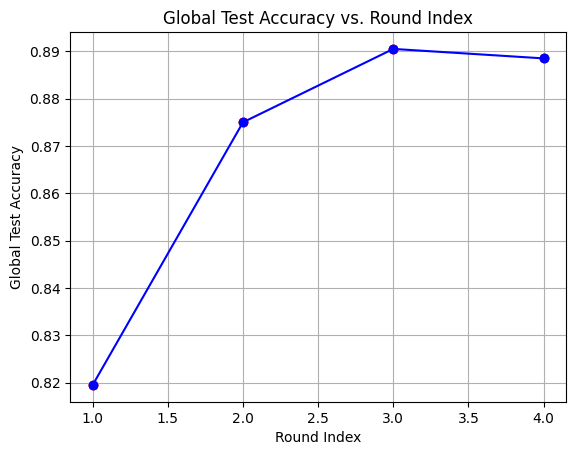

In [32]:
import matplotlib.pyplot as plt

# Example points (replace with your own x and y values)
x = accuracy_plot_x
y = accuracy_plot_y

# Scatter plot of points
plt.scatter(x, y, color='red', zorder=2)

# Plot line with markers
plt.plot(x, y, marker='o', linestyle='-', color='blue')

# Highlight the points explicitly if you like
plt.scatter(x, y, color='red')

plt.xlabel("Round Index")
plt.ylabel("Global Test Accuracy")
plt.title("Global Test Accuracy vs. Round Index")
plt.grid(True)
plt.show()
